In [1]:
import os
import pandas as pd
import numpy as np
np.random.seed(42)

import matplotlib.pyplot as plt

from sklearn import set_config
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeRegressor

## Datenimport
Quelle der Daten: https://data.milwaukee.gov/dataset/property-sales-data

In [2]:
FILEPATH = os.path.join("..", "input", "armslengthsales_2022_valid.csv")

In [3]:
df = pd.read_csv(FILEPATH)

# Hilfsfunktion(en)

In [4]:
def print_evaluation(name, cv, pipe, train_data, test_data, y, X):
    print(f"{name} - Cross validation {cv}")
    print(f"{name} -     In-sample -  mae: {mean_absolute_error(y_true=train_data[y], y_pred=pipe.predict(train_data[X])):.2f}")
    print(f"{name} -     In-sample - mape: {mean_absolute_percentage_error(y_true=train_data[y], y_pred=pipe.predict(train_data[X])):.2f}%")
    print(f"{name} - Out-of-sample -  mae: {mean_absolute_error(y_true=test_data[y], y_pred=pipe.predict(test_data[X])):.2f}")
    print(f"{name} - Out-of-sample - mape: {mean_absolute_percentage_error(y_true=test_data[y], y_pred=pipe.predict(test_data[X])):.2f}%")
    print(f"{name} - Out-of-sample - rsme: {np.sqrt(mean_squared_error(y_true=test_data[y], y_pred=pipe.predict(test_data[X]))):.2f}")
    print(f"{name} - Out-of-sample -   r2: {pipe.score(X=test_data[X], y=test_data[y]):.2f}")

In [5]:
def plot_train_vs_test_predictions(pipe, train_data, test_data, X, y):
    train_predictions = pipe.predict(train_data[X])
    test_predictions = pipe.predict(test_data[X])

    plt.figure(figsize=(10, 5))
    plt.scatter(train_predictions, train_data[y], color='blue', label='Trainingsdaten')
    plt.scatter(test_predictions, test_data[y], color='red', label='Testdaten')
    plt.xlabel('Vorhergesagter Verkaufspreis')
    plt.ylabel('Tatsächlicher Verkaufspreis')
    plt.title('Vorhersagen vs. Tatsächliche Werte')
    plt.ticklabel_format(style='plain', axis='x') # Wird benötigt, damit die Werte nicht als 0,2 x 10^X dargestellt werden sondern als Ganzzahlen
    plt.ticklabel_format(style='plain', axis='y') # Wird benötigt, damit die Werte nicht als 0,2 x 10^X dargestellt werden sondern als Ganzzahlen
    plt.legend()
    plt.show()

In [6]:
def plot_train_vs_test_cross_validation(cv_results):
    train_scores = cv_results['train_score']
    test_scores = cv_results['test_score']
    
    plt.figure(figsize=(14, 6))
    plt.plot(range(len(train_scores)), train_scores, label='Train Score', marker='o')
    plt.plot(range(len(test_scores)), test_scores, label='Test Score', marker='x')
    plt.xticks(rotation=45)
    plt.xlabel('Steps')
    plt.ylabel('Test')
    plt.title(f'Train vs Test Scores over time')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Preprocessing

In [7]:
df["Bath"] = df["Fbath"]+(df["Hbath"]/2)
df["Total_Rooms"] = df["Bdrms"] + df["Rooms"]

# dropped features wird nicht verwendet, ist lediglich eine Kennzeichnung der nicht verwendeten Features
dropped_features = ["PropertyID", "taxkey", "Address", "CondoProject", "PropType", "Style", "Sale_date", "Fbath", "Hbath", "Bdrms", "Rooms"]

num_features = ["Stories", "Year_Built", "FinishedSqft", "Units", "Bath", "Lotsize", "Total_Rooms"]
cat_features = ["District", "nbhd", "Extwall"]

df['District'] = df['District'].astype(object)
df['nbhd'] = df['nbhd'].astype(object)

In [8]:
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

In [9]:
y = ["Sale_price"]
X = [*num_features, *cat_features]

In [10]:
set_config(transform_output="pandas")

# Auffüllen der fehlenden Numerischen Werte mit dem Durchschnitt + Anwendung StandardScaler
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
])

# Auffüllen der fehlenden Kategorischen Werte mit den häufigsten Werten + Anwendung OneHotEncoder
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore')),
])

prep = ColumnTransformer(
    remainder="drop",
    transformers=[
        ("num", num_transformer, num_features),
        ("cat", cat_transformer, cat_features),
    ],
)

prep

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['Stories', 'Year_Built', 'FinishedSqft',
                                  'Units', 'Bath', 'Lotsize', 'Total_Rooms']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['District', 'nbhd', 'Extwall'])])

In [11]:
prep_transformed = prep.fit_transform(X=train_data[X])
prep_transformed

,num__Stories,num__Year_Built,num__FinishedSqft,num__Units,num__Bath,num__Lotsize,num__Total_Rooms,cat__District_1,cat__District_2,cat__District_3,...,cat__Extwall_Fiber Cement/Hardiplank,cat__Extwall_Masonary Frame,cat__Extwall_Masonry/Frame,cat__Extwall_Metal Siding,cat__Extwall_Other,cat__Extwall_Precast Masonary,cat__Extwall_Prem Wood,cat__Extwall_Stone,cat__Extwall_Stucco,cat__Extwall_Wood
59,2.040804,0.309840,-0.148994,-0.069573,-0.115614,-0.250146,-0.624829,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3717,1.123395,-0.107680,0.151981,0.333957,-2.092238,-0.104320,-1.643368,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
787,-0.711424,0.265423,-0.138065,-0.069573,-0.115614,-0.054248,-0.624829,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2540,0.205985,-0.311998,-0.121344,-0.069573,0.543260,-0.117382,-0.115560,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6225,0.205985,-0.089913,-0.048013,-0.002318,0.543260,-0.112956,0.054196,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3772,-0.711424,-0.143213,-0.136535,-0.069573,-0.774489,-0.077469,-0.455073,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5191,-0.711424,-0.463015,-0.168009,-0.069573,-0.774489,-0.141330,-0.794586,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5226,-0.711424,-0.320881,-0.095006,-0.002318,0.543260,-0.123188,0.223953,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5390,-0.711424,-0.063263,-0.161452,-0.069573,-0.774489,-0.047499,-0.455073,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Modelltraining und -vergleich

In [12]:
models = [
    ('Decision Tree', DecisionTreeRegressor(random_state=42, max_depth=5)),
    ('Random Forest', RandomForestRegressor(random_state=42, max_depth=5, n_estimators=100)),
    ('Gradient Boosting', GradientBoostingRegressor(random_state=42, max_depth=5, n_estimators=100)),
    ('K-nearest Neighbors', KNeighborsRegressor(n_neighbors=5))
]

for name, model in models:
    pipe = Pipeline(steps=[
        ('preprocessor', prep),
        ('model', model)
    ])

    pipe.fit(X=train_data[X], y=train_data[y].values.ravel())
    cv = cross_val_score(estimator=pipe[-1], X=prep.fit_transform(train_data[X]), y=train_data[y], cv=3, n_jobs=4)

    print_evaluation(name, cv, pipe, train_data, test_data, y, X)

Decision Tree - Cross validation [0.64641186 0.77699636 0.07308171]
Decision Tree -     In-sample -  mae: 94423.57
Decision Tree -     In-sample - mape: 0.62%
Decision Tree - Out-of-sample -  mae: 97848.69
Decision Tree - Out-of-sample - mape: 0.54%
Decision Tree - Out-of-sample - rsme: 251531.28
Decision Tree - Out-of-sample -   r2: 0.70
Random Forest - Cross validation [0.75935213 0.76641438 0.57136656]
Random Forest -     In-sample -  mae: 95309.49
Random Forest -     In-sample - mape: 0.61%
Random Forest - Out-of-sample -  mae: 91521.18
Random Forest - Out-of-sample - mape: 0.53%
Random Forest - Out-of-sample - rsme: 197900.18
Random Forest - Out-of-sample -   r2: 0.81
Gradient Boosting - Cross validation [0.57602045 0.66330714 0.27579612]
Gradient Boosting -     In-sample -  mae: 44430.38
Gradient Boosting -     In-sample - mape: 0.29%
Gradient Boosting - Out-of-sample -  mae: 55169.14
Gradient Boosting - Out-of-sample - mape: 0.27%
Gradient Boosting - Out-of-sample - rsme: 132915

## Hyperparameter-Optimierung
Die Hyperparameter-Optimierung erfolgt in einem separaten Notebook ```notebooks/hyperparameter_optimierung.ipynb```.  
Im folgenden Codeabschnitt werden die besten Ergebnisse angewandt und gegenübergestellt.

In [13]:
models = [
    ('Decision Tree', DecisionTreeRegressor(random_state=42, max_depth=20, min_samples_leaf=4, min_samples_split=2)),
    ('Random Forest', RandomForestRegressor(random_state=42, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50)),
    ('Gradient Boosting', GradientBoostingRegressor(random_state=42, learning_rate=0.1, max_depth=7, min_samples_leaf=1, min_samples_split=10, n_estimators=200)),
    ('K-nearest Neighbors', KNeighborsRegressor(algorithm='ball_tree', n_neighbors=9, weights='distance'))
]

for name, model in models:
    pipe = Pipeline(steps=[
        ('preprocessor', prep),
        ('model', model)
    ])

    pipe.fit(X=train_data[X], y=train_data[y].values.ravel())
    cv = cross_val_score(estimator=pipe[-1], X=prep.fit_transform(train_data[X]), y=train_data[y], cv=5, n_jobs=4)

    print_evaluation(name, cv, pipe, train_data, test_data, y, X)

Decision Tree - Cross validation [0.07767868 0.64110744 0.75925761 0.20669331 0.58827151]
Decision Tree -     In-sample -  mae: 57226.61
Decision Tree -     In-sample - mape: 0.24%
Decision Tree - Out-of-sample -  mae: 63664.86
Decision Tree - Out-of-sample - mape: 0.28%
Decision Tree - Out-of-sample - rsme: 185745.75
Decision Tree - Out-of-sample -   r2: 0.84
Random Forest - Cross validation [0.6981335  0.6909435  0.7748625  0.60573814 0.70539917]
Random Forest -     In-sample -  mae: 34280.80
Random Forest -     In-sample - mape: 0.12%
Random Forest - Out-of-sample -  mae: 53278.53
Random Forest - Out-of-sample - mape: 0.23%
Random Forest - Out-of-sample - rsme: 176705.80
Random Forest - Out-of-sample -   r2: 0.85
Gradient Boosting - Cross validation [0.62413351 0.75087717 0.80892122 0.42882207 0.80183022]
Gradient Boosting -     In-sample -  mae: 33911.97
Gradient Boosting -     In-sample - mape: 0.21%
Gradient Boosting - Out-of-sample -  mae: 51948.40
Gradient Boosting - Out-of-sam

## Random Forest - Train vs Test

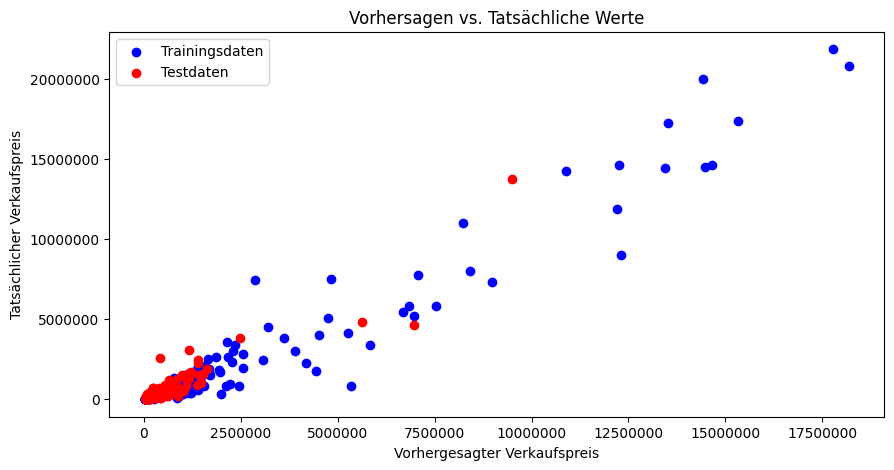

In [14]:
pipe = Pipeline(steps=[
        ('preprocessor', prep),
        ('Random Forest', RandomForestRegressor(random_state=42, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50))
    ])

pipe.fit(train_data[X], train_data[y].values.ravel())

plot_train_vs_test_predictions(pipe, train_data, test_data, X, y)

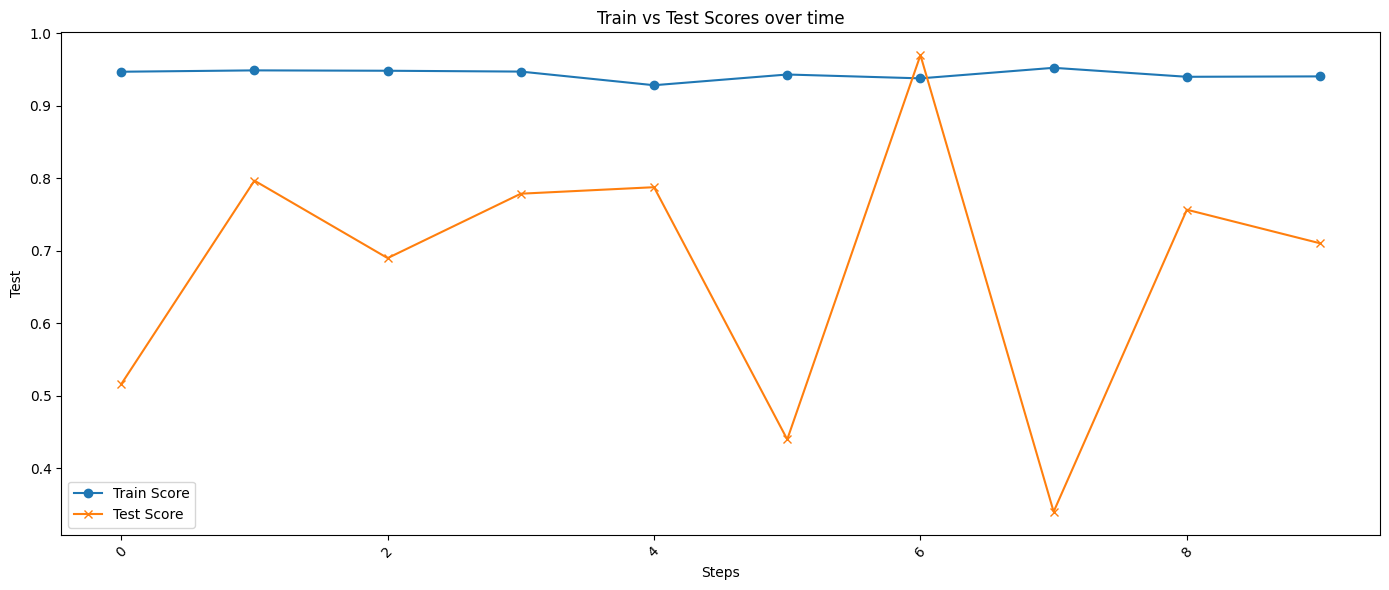

In [15]:
cv_results = cross_validate(estimator=pipe[-1], X=prep.fit_transform(train_data[X]), y=train_data[y].values.ravel(), cv=10, n_jobs=4, return_train_score=True)
plot_train_vs_test_cross_validation(cv_results)

## Gradient Boosting - Train vs Test

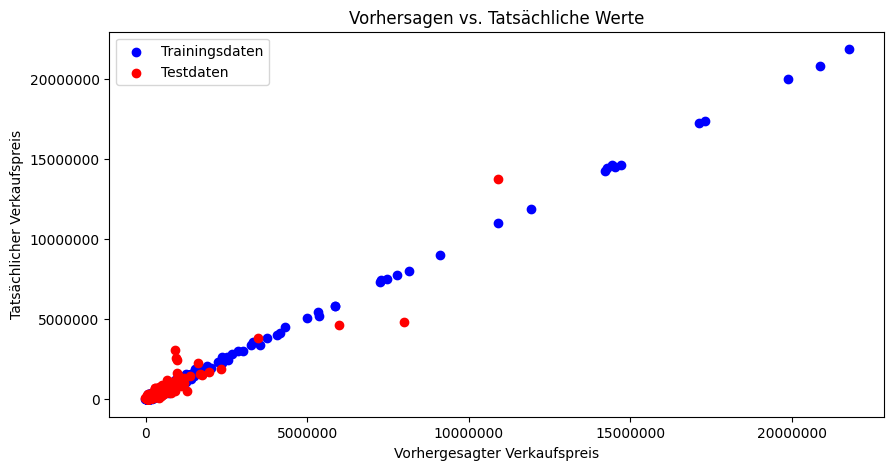

In [16]:
pipe = Pipeline(steps=[
        ('preprocessor', prep),
        ('Gradient Boosting', GradientBoostingRegressor(random_state=42, learning_rate=0.1, max_depth=7, min_samples_leaf=1, min_samples_split=10, n_estimators=200))
    ])

pipe.fit(train_data[X], train_data[y].values.ravel())

plot_train_vs_test_predictions(pipe, train_data, test_data, X, y)

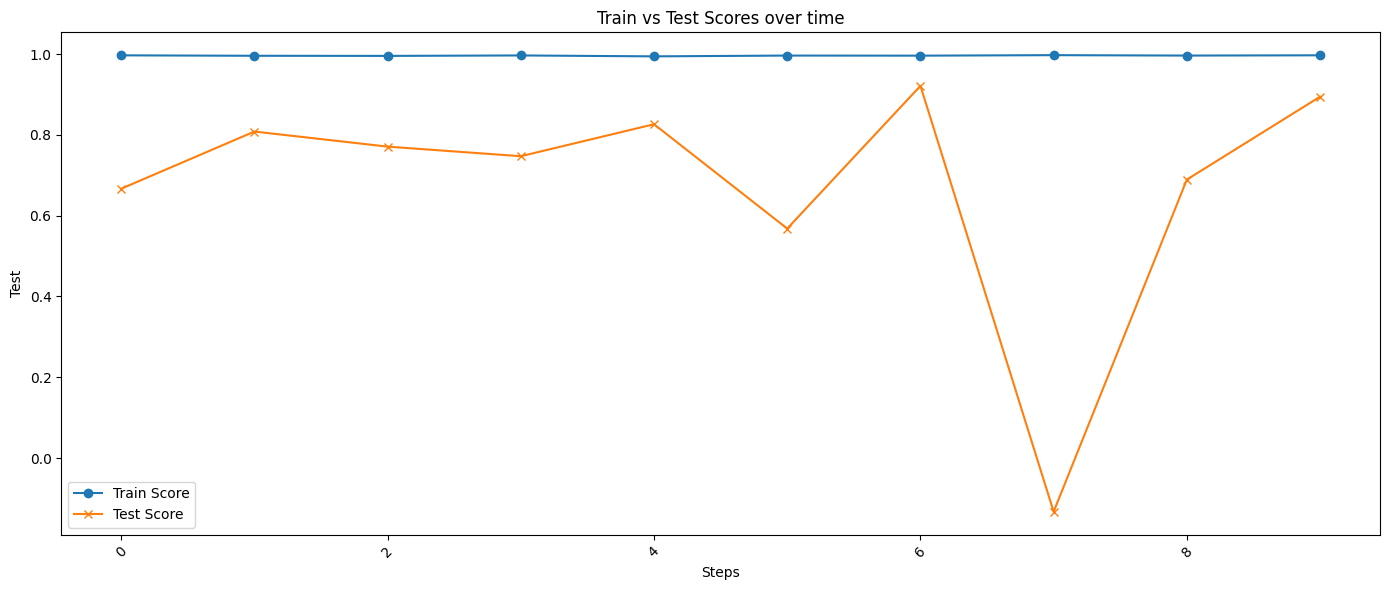

In [17]:
cv_results = cross_validate(estimator=pipe[-1], X=prep.fit_transform(train_data[X]), y=train_data[y].values.ravel(), cv=10, n_jobs=4, return_train_score=True)
plot_train_vs_test_cross_validation(cv_results)

## Optimierung der zwei besten Modelle

### Erweitertes Cleansing basierend auf der Verteilung der Features

In [18]:
df = df[df['Stories'] < 10]
df = df[df['Year_Built'] > 1800]
df = df[df['FinishedSqft'] < 10000]
df = df[df['Lotsize'] < 100000]
df = df[df['Units'] < 15]
df = df[df['Sale_price'] < 1500000]

train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)
len(df)

6954

Random Forest

K-nearest Neighbors - Cross validation [0.74039482 0.61621914 0.72830321 0.34628846 0.62234602]
K-nearest Neighbors -     In-sample -  mae: 25792.26
K-nearest Neighbors -     In-sample - mape: 0.17%
K-nearest Neighbors - Out-of-sample -  mae: 36974.31
K-nearest Neighbors - Out-of-sample - mape: 0.20%
K-nearest Neighbors - Out-of-sample - rsme: 64017.94
K-nearest Neighbors - Out-of-sample -   r2: 0.77


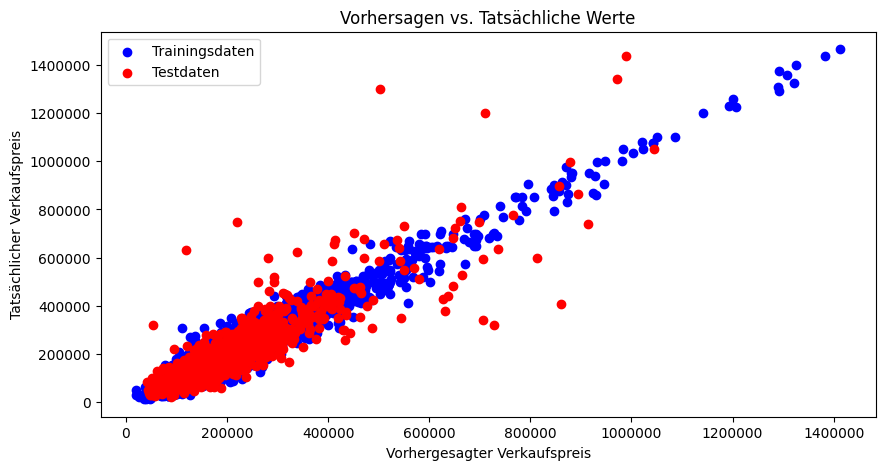

In [19]:
pipe = Pipeline(steps=[
        ('preprocessor', prep),
        ('Gradient Boosting', GradientBoostingRegressor(random_state=42, learning_rate=0.1, max_depth=7, min_samples_leaf=1, min_samples_split=10, n_estimators=200))
    ])

pipe.fit(train_data[X], train_data[y].values.ravel())

print_evaluation(name, cv, pipe, train_data, test_data, y, X)
plot_train_vs_test_predictions(pipe, train_data, test_data, X, y)

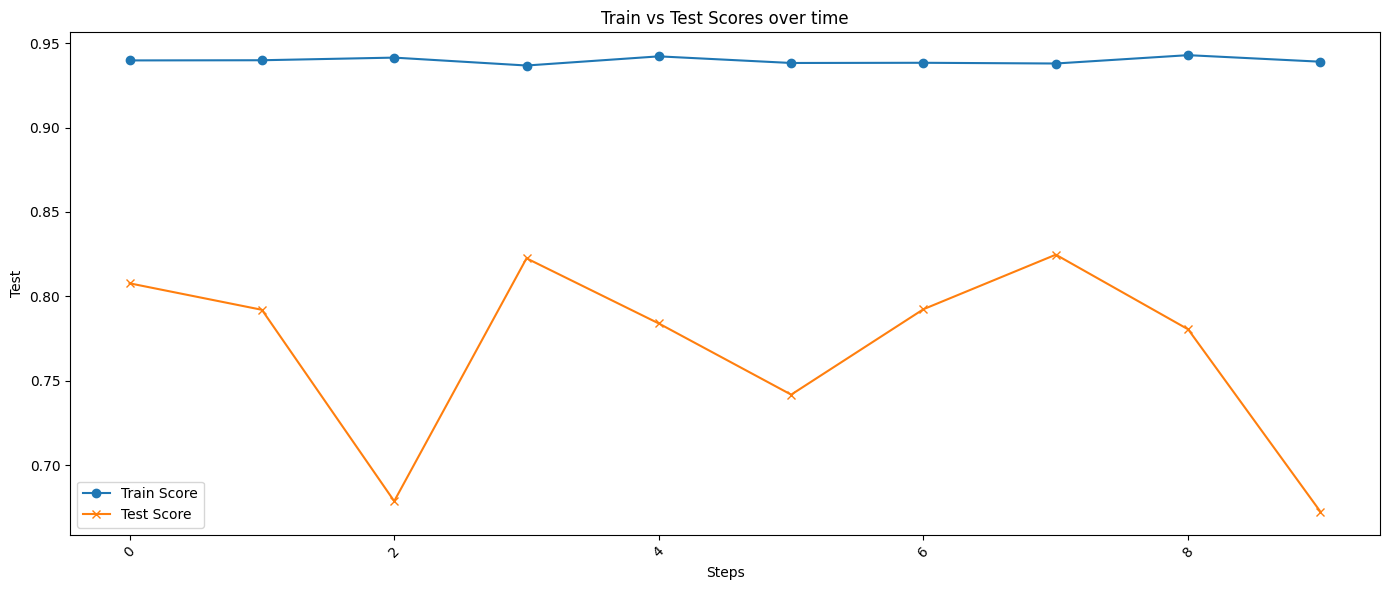

In [20]:
cv_results = cross_validate(estimator=pipe[-1], X=prep.fit_transform(train_data[X]), y=train_data[y].values.ravel(), cv=10, n_jobs=4, return_train_score=True)
plot_train_vs_test_cross_validation(cv_results)

Gradient Boosting

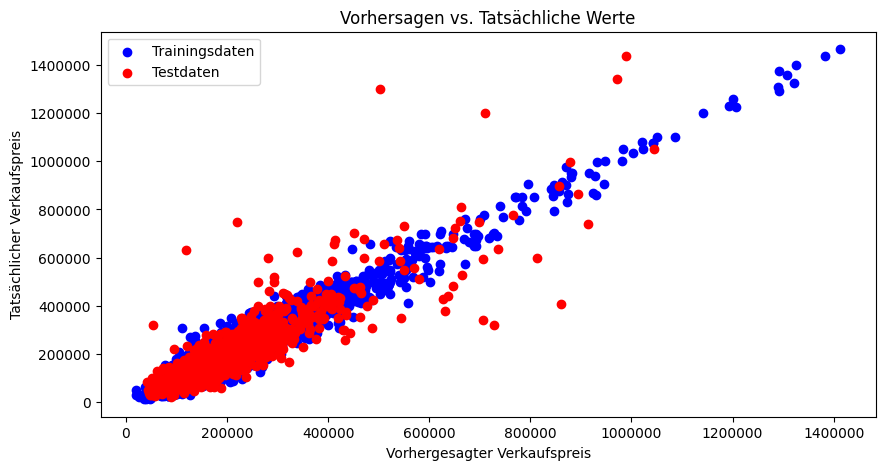

In [21]:
pipe = Pipeline(steps=[
        ('preprocessor', prep),
        ('Gradient Boosting', GradientBoostingRegressor(random_state=42, learning_rate=0.1, max_depth=7, min_samples_leaf=1, min_samples_split=10, n_estimators=200))
    ])

pipe.fit(train_data[X], train_data[y].values.ravel())

plot_train_vs_test_predictions(pipe, train_data, test_data, X, y)

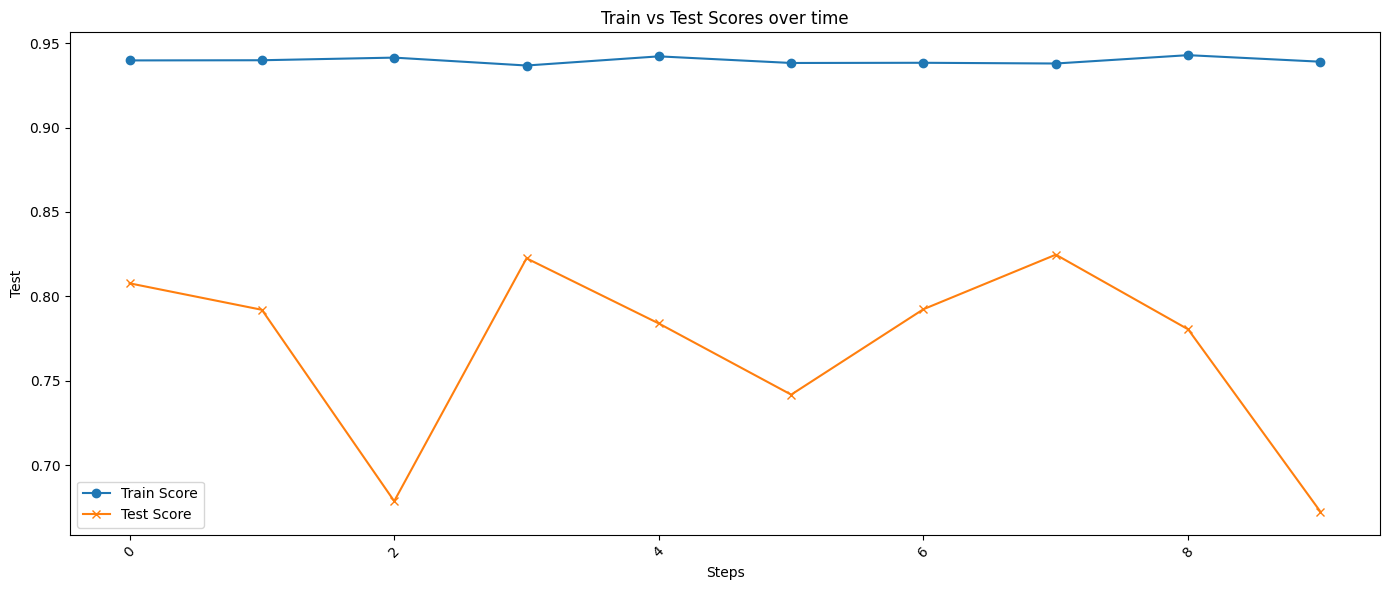

In [22]:
cv_results = cross_validate(estimator=pipe[-1], X=prep.fit_transform(train_data[X]), y=train_data[y].values.ravel(), cv=10, n_jobs=4, return_train_score=True)
plot_train_vs_test_cross_validation(cv_results)